As per notebook convention, imports are handled at the beginning

In [1]:
import copy
import json
import math
import time
from statistics import mean
from typing import List, Tuple, Optional

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from torch import Tensor
from torch.autograd import Variable
from torch.nn.init import xavier_uniform_

print("Cuda is available: ", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Cuda is available:  True


# Data
## Preprocessing
This the data preprocessing "pipeline". These single responsibility unary functions are used to transform the
raw data collected and split via the scala spark job into usable source and target tensors

In [2]:
# reads spark files and puts them into lines
def read_multi_json_objects_file(filename: str) -> List[dict]:
    with open(filename, 'r') as file:
        return [json.loads(line) for line in file]

# splits lines into user -> (history+target)
def extract_raw_history_data_from(data):
    return [history["value"] for history in data ]

In [3]:
def l2_normalization(data: Tensor) -> Tensor:
    return F.normalize(data, p=2, dim=2)

# creates tensors from history
def as_tensor(bert_histories: List[List[List[float]]]) -> Tensor:

    # essentially create one giant batch
    histories = [ torch.tensor(history).unsqueeze(1) for history in bert_histories ]
    return torch.cat(histories, 1) # either normalize or not, subject to testing

In [4]:
pert_padding_vector = torch.zeros(768).to(device)

# this has to be precalculated as per-batch calculation doubles traning time
# creates a nxm matrix
def generate_padding_mask(data: Tensor) -> Tensor:
            batch_paddings = []

            for batch in range(data.shape[1]):
                sequence_padding = torch.tensor([
                    torch.eq(data[article, batch, :], pert_padding_vector).all() # true if padding
                        for article in range(data.shape[0])
                ]).to(device)
                batch_paddings.append(sequence_padding)

            return torch.stack(batch_paddings, dim=0).detach().to(device)

Our data is prepared using the functions implemented above

In [5]:
# shape of these is [x0, ..., xn + 1], so 2 longer than seq_length
# this is because we're going to split at 0-15, 1-16, 2-17 for encoder S, decoder Sd and target St respectively
train_test_data = read_multi_json_objects_file('../data/seq_16/train/6k.json')
validation_data = read_multi_json_objects_file('../data/seq_16/val/600.json')

In [6]:
train_test_histories = extract_raw_history_data_from(train_test_data)
validation_histories = extract_raw_history_data_from(validation_data)

Train and test splits are defined

In [7]:
train_test_split = 0.8

samples = len(train_test_histories)

train_samples = int(samples * train_test_split)
val_samples = samples - train_samples

In [8]:
unbatched_train_data = train_test_histories[:train_samples]
unbatched_test_data = train_test_histories[train_samples:]
unbatched_val_data = validation_histories

In [9]:
# Expand and push data to cuda device
train_data  = as_tensor(unbatched_train_data).to(device)
test_data   = as_tensor(unbatched_test_data).to(device)
val_data    = as_tensor(unbatched_val_data).to(device)

In [10]:
# Precompute padding maps and push to cuda device
train_padding_map = generate_padding_mask(train_data).to(device)
test_padding_map  = generate_padding_mask(test_data).to(device)
val_padding_map   = generate_padding_mask(val_data).to(device)

# Model

## Positional Encoding
RelativePositionalEncoding module injects some information about the relative or absolute position of the tokens in the sequence. The positional encodings have the same dimension as the embeddings so that the two can be summed. Here, we use sine and cosine functions of different frequencies.

In [11]:
class RelativePositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, model_dimension, dropout_rate, max_len=5000):
        super(RelativePositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout_rate)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, model_dimension)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_dimension, 2) * -(math.log(10000.0) / model_dimension))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, unencoded):
        encoded = unencoded + Variable(self.pe[:, :unencoded.size(1)], requires_grad=False)
        return self.dropout(encoded)

## Encoder/Decoder definitions

In [12]:
def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

In [13]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)

        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = nn.ReLU()

    def forward(self, src: Tensor, src_mask: Tensor = None, src_key_padding_mask: Tensor = None) -> Tuple[Tensor, Tensor]:
        res = src
        src = self.norm1(src)
        src, attn = self.self_attn.forward(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)
        src = res + self.dropout1(src)

        res = src
        src = self.norm2(src)
        src = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = res + self.dropout2(src)

        return src, attn

In [14]:
class TransformerEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers):
        super(TransformerEncoder, self).__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers

    def forward(self, src: Tensor, mask: Tensor = None, src_key_padding_mask: Tensor = None) -> Tuple[Tensor, Tensor]:
        output = src
        n_self_attn = []
        for mod in self.layers:
            output, self_attn = mod(output, src_mask=mask, src_key_padding_mask=src_key_padding_mask)
            n_self_attn.append(self_attn.unsqueeze(dim=0))

        return output, torch.cat(n_self_attn, 0).detach()

In [15]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)

        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = nn.ReLU()

    def forward(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor = None, memory_mask: Tensor = None,
                tgt_key_padding_mask: Tensor = None, memory_key_padding_mask: Tensor = None) -> Tuple[Tensor, Tensor, Tensor]:
        res = tgt
        tgt = self.norm1(tgt)
        tgt, self_attn = self.self_attn(tgt, tgt, tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask)
        tgt = res + self.dropout1(tgt)

        res = tgt
        tgt = self.norm2(tgt)
        tgt, mult_attn = self.multihead_attn(tgt, memory, memory, attn_mask=memory_mask, key_padding_mask=memory_key_padding_mask)
        tgt = res + self.dropout2(tgt)

        res = tgt
        tgt = self.norm3(tgt)
        tgt = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = res + self.dropout3(tgt)

        return tgt, self_attn, mult_attn

In [16]:
class TransformerDecoder(nn.Module):
    def __init__(self, decoder_layer, num_layers):
        super(TransformerDecoder, self).__init__()
        self.layers = _get_clones(decoder_layer, num_layers)
        self.num_layers = num_layers

    def forward(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor = None,
                memory_mask: Tensor = None, tgt_key_padding_mask: Tensor = None,
                memory_key_padding_mask: Tensor = None) -> Tuple[Tensor, Tensor, Tensor]:
        output = tgt
        for mod in self.layers:
            output, self_attn, mult_attn = mod(output, memory, tgt_mask=tgt_mask,
                         memory_mask=memory_mask,
                         tgt_key_padding_mask=tgt_key_padding_mask,
                         memory_key_padding_mask=memory_key_padding_mask)

        return output, self_attn.detach(), mult_attn.detach()

## Input/Output definition

In [17]:
class Input(nn.Module):
    def __init__(self, model_dimension, embedding_dimension, dropout):
        super().__init__()
        self.linear              = nn.Linear(embedding_dimension, model_dimension)
        self.positional_encoding = RelativePositionalEncoding(model_dimension, dropout)

    def forward(self, data) -> Tensor:
        data = l2_normalization(data)
        data = self.linear(data) * math.sqrt(model_dimension)
        data = self.positional_encoding(data)
        return data

class Output(nn.Module):
    def __init__(self, model_dimension, feedforward_dimension, embedding_dimension, dropout):
        super().__init__()
        self.widen           = nn.Linear(model_dimension, feedforward_dimension)
        self.relu            = nn.ReLU()
        self.dropout         = nn.Dropout(dropout)
        self.shrink          = nn.Linear(feedforward_dimension, embedding_dimension)
        self.hard_shrink     = nn.Hardshrink(0.01)

    def forward(self, data) -> Tensor:
        data = self.widen(data)
        data = self.relu(data)
        data = self.dropout(data)
        data = self.shrink(data)
        data = self.hard_shrink(data)
        return data

## Model definition

In [18]:
class BertHistoryTransformer(nn.Module):
    def __init__(
        self,
        decoder_seq_length,
        embedding_dimension,
        model_dimension,
        encoder_layers,
        decoder_layers,
        heads,
        dropout
    ):
        super().__init__()
        self.model_dimension = model_dimension
        self.padding = torch.zeros(embedding_dimension).to(device)
        self.mask = self.generate_square_subsequent_mask(decoder_seq_length)

        self.pre_ln_norm = nn.LayerNorm(model_dimension).to(device)

        self.encoder = Input(model_dimension, embedding_dimension, dropout).to(device)
        # -----------------------------------------------------------------------------------------
        encoder_layer = TransformerEncoderLayer(
            d_model=model_dimension,
            nhead=heads,
            dim_feedforward=feedforward_dimension,
            dropout=dropout
        )
        self.transformer_enc = TransformerEncoder(encoder_layer, encoder_layers).to(device)
        # -----------------------------------------------------------------------------------------
        decoder_layer = TransformerDecoderLayer(
            d_model=model_dimension,
            nhead=heads,
            dim_feedforward=feedforward_dimension,
            dropout=dropout
        )
        self.transformer_dec = TransformerDecoder(decoder_layer, decoder_layers).to(device)
        # -----------------------------------------------------------------------------------------
        self.decoder = Output(model_dimension, feedforward_dimension, embedding_dimension, dropout).to(device)

        self.init_weights()

    def init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                xavier_uniform_(p)

    def generate_square_subsequent_mask(self, sz: int) -> Tensor:
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask.to(device)

    # -----------------------------------------------------------------------------------------
    def transform(self, src, tgt) -> Tuple[Tensor, Tensor, Tensor, Tensor]:
        memory, enc_att           = self.transformer_enc.forward(src)
        memory, dec_att, mult_att = self.transformer_dec.forward(tgt, self.pre_ln_norm(memory), tgt_mask=self.mask)

        return memory, enc_att, dec_att, mult_att

    # -----------------------------------------------------------------------------------------
    def _step(self, src, tgt, src_key_padding_mask=None) -> Tuple[Tensor, Tensor, Tensor, Tensor]:
        source_memory = self.encoder(src)
        target_memory = self.encoder(tgt)

        memory, enc_att, dec_attn, mult_attn = self.transform(source_memory, target_memory)
        output = self.decoder(memory)

        return output, enc_att, dec_attn, mult_attn

    def forward(self, src, tgt, src_key_padding_mask=None) -> Tensor:
        return self._step(src, tgt, src_key_padding_mask)[0]

    def predict(self, src, tgt, src_key_padding_mask=None) -> Tuple[Tensor, Tensor, Tensor, Tensor]:
        with torch.no_grad():
            return self._step(src, tgt, src_key_padding_mask)

## Batching

Semantically part of the training loop, this function stacks tensors of size _seq-length x channels_ into tensors of
dimensions _seq-length x batch-size x channels_, adhering to the 'named tensor' convention.

In [19]:
# batchifies and expands source to encoder source, decoder source, target, and padding
def get_batch(source: Tensor, src_padding: Optional[Tensor], batch_offset) -> Tuple[Tensor, Tensor, Tensor, Tensor]:
    current_batch_size = min(batch_size, source.shape[1] - 1 - batch_offset)

    # source is already sliced per sequence, so we address batches only by offset
    batch: Tensor   = source[:, batch_offset : batch_offset + current_batch_size, :]
    if src_padding != None:
        padding: Tensor = src_padding[batch_offset : batch_offset + current_batch_size, :]
    else:
        padding: Tensor = pert_padding_vector

    # calculate offsets for decoder and target sequence
    dec_start = max_seq_length - decoder_seq_length - 1
    dec_end   = dec_start + decoder_seq_length

    sources_enc: Tensor = batch[0            :seq_length , :, :]
    sources_dec: Tensor = batch[dec_start    :dec_end    , :, :]
    targets: Tensor     = batch[dec_start + 1:dec_end + 1, :, :]

    # Careful: padding has length of scala seq length, so it has to be sliced
    return sources_enc, sources_dec, targets, padding

# Training


## Loss

In [20]:
# LOSS FUNCTION----------------------------------------------------------------
cosine_loss = nn.CosineEmbeddingLoss()
eucl_loss = nn.MSELoss()

def calculate_loss(pred: Tensor, target: Tensor) -> Tensor:
    #return cosine_loss(
    #    pred.reshape(-1, embedding_dimension),
    #    target.reshape(-1, embedding_dimension),
    #    target=similar_dissimilar_label[:(pred.shape[0]) * pred.shape[1]]
    #)
    #return torch.sqrt(eucl_loss(pred.reshape(-1), target.reshape(-1)) + 1e-6)
    return torch.sqrt(
        eucl_loss( # all but the last item
            pred[:decoder_seq_length-1, : , :].reshape(-1),
            target[:decoder_seq_length-1, : , :].reshape(-1)
            ) + 1e-6 # plus epsilon for RMSE
    ) + (1.3 * torch.sqrt(
        eucl_loss( # the last item - our real prediction - is weighted more heavily
            pred[decoder_seq_length-1:decoder_seq_length, : , :].reshape(-1),
            target[decoder_seq_length-1:decoder_seq_length, : , :].reshape(-1),
        ) + 1e-6 # plus epsilon for RMSE
    ))
    #return cosine_loss(
    #    pred.reshape(-1, embedding_dimension),
    #    target.reshape(-1, embedding_dimension),
    #    target=similar_dissimilar_label[:(pred.shape[0]) * pred.shape[1]]
    #) + eucl_loss(pred.reshape(-1), target.reshape(-1))
    #return mse_loss.forward(
    #    pred[:seq_length-1, : , :].reshape(-1),
    #    target[:seq_length-1, : , :].reshape(-1),
    #) + cosine_loss.forward(
    #    pred[seq_length-1:seq_length, : , :].reshape(-1, embedding_dimension),
    #    target[seq_length-1:seq_length, : , :].reshape(-1, embedding_dimension),
    #    target=similar_dissimilar_label[:pred.shape[1]]
    #)

## Train and evaluation loops

In [21]:
def train():
    model.train() # Turn on the train mode
    total_loss = []
    start_time = time.time()
    log_interval = max(1, train_data.shape[1] / batch_size // 2)



    for batch_number, batch_offset in enumerate(range(0, train_data.shape[1] - 1, batch_size)):
        enc_source, dec_source, target, pad = get_batch(train_data, train_padding_map, batch_offset)

        optimizer.zero_grad()
        output: Tensor = model.forward(enc_source, dec_source, None)

        current_loss: Tensor = calculate_loss(output, target)

        current_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss.append(current_loss.detach().item())

        if batch_number + 1 % log_interval == 0:
            cur_loss = mean(total_loss)

            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                              'lr {:02.6f} | ms/batch {:5.2f} | '
                              'loss {:5.4f} | ppl {:8.2f}'.format(
                                    epoch,
                                    batch_number + 1,
                                    train_data.shape[1] // batch_size,
                                    scheduler.get_last_lr()[0],
                                    elapsed * 1000 / log_interval,
                                    cur_loss,
                                    math.exp(cur_loss)
                                )
            )
            total_loss = [0]
            start_time = time.time()

def evaluate(eval_model: BertHistoryTransformer, data_source: Tensor) -> Tuple[float, Tensor, Tensor, Tensor]:
    eval_model.eval() # Turn on the evaluation mode
    total_loss = []

    with torch.no_grad():
        for batch, batch_offset in enumerate(range(0, data_source.shape[1] - 1, batch_size)):
            enc_source, dec_source, target, pad = get_batch(data_source, None, batch_offset)
            output, enc_attn, dec_attn, mult_attn = eval_model.predict(enc_source, dec_source, pad)

            current_loss: Tensor = calculate_loss(output, target).detach().item()

            total_loss.append(current_loss)
    return mean(total_loss), enc_attn, dec_attn, mult_attn

## Parameters and Hyperparameters, Model instantiation, Loss defintion
Training is started

In [22]:
loss_over_time = []

# TRAINING TIME----------------------------------------------------------------
max_epochs = 1000 # If convergence isn't reached when reached we just stop
warmup_epochs = 400
convergence_grace_epochs = 80000

# BATCHING & DECODER_SEQ_LENGHT------------------------------------------------
#batch_size = 128
batch_size = 256
#batch_size = 512
#batch_size = 640
#batch_size = 896
#batch_size = 1024
#batch_size = 1536
#batch_size = 2048
decoder_seq_length = 16

# MODEL HYPERPARAMS------------------------------------------------------------
embedding_dimension = 768 # the size of vocabulary
model_dimension = 256
feedforward_dimension = 2048
encoder_layers = 2 # 2 performed best
decoder_layers = 2 # subject to testing
heads = 4 # the number of heads for multiheadattention, 4 performed best
dropout = 0.2 # the dropout value

# MODEL INSTANTIATION----------------------------------------------------------
model = BertHistoryTransformer(
    decoder_seq_length=decoder_seq_length,
    embedding_dimension=embedding_dimension,
    model_dimension=model_dimension,
    encoder_layers=encoder_layers,
    decoder_layers=decoder_layers,
    heads=heads,
    dropout=dropout
)

# LR & TRAINING LOOP & OPTIMIZER-----------------------------------------------
lr = 0.02

def calculate_lr(step: int) -> float:
    step += 1
    return lr * min(pow(step, -0.5), step * pow(warmup_epochs, -1.5))

optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, calculate_lr)

best_test_loss = float("inf")
best_model = None

no_improvement_epoch_count = 0

print('| ==== Got {:6d} training examples, splitting into {:4d} batches a {:4d} examples '.format(
    train_data.shape[1], train_data.shape[1] // batch_size, batch_size
))

# -----------------------------------------------------------------------------
seq_length = 16 # this is to be adjusted in the scala code
max_seq_length = 18

similar_dissimilar_label = torch.ones(decoder_seq_length * batch_size * embedding_dimension).to(device)
torch.cuda.empty_cache()

for epoch in range(1, max_epochs):
    # check if we've converged
    if no_improvement_epoch_count > convergence_grace_epochs:
        print("| ----------------------- CONVERGENCE GRACE PERIOD SURPASSED")
        break

    epoch_start_time = time.time()
    train()

    # TODO: put all images into tensorboard so we can watch the attention shift
    test_loss, enc_att, dec_att, mult_att = evaluate(model, test_data)
    loss_over_time.append(test_loss)

    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | test loss {:5.4f} | test ppl {:8.2f}'.format(
        epoch, (time.time() - epoch_start_time), test_loss, math.exp(test_loss))
    )
    print('-' * 89)


    if math.isclose(test_loss, best_test_loss, abs_tol=0.0001):
        no_improvement_epoch_count += 1

    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_model = model

    scheduler.step()

| ==== Got   4800 training examples, splitting into   37 batches a  128 examples 
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 14.59s | test loss 5.9339 | test ppl   377.63
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 14.07s | test loss 5.6964 | test ppl   297.79
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   3 | time: 14.10s | test loss 5.3617 | test ppl   213.08
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end of epoch   4 | time: 14.11s | test loss 4.9563 | test ppl   142

KeyboardInterrupt: 

# Evaluation

In [23]:
val_loss, a, b, c = evaluate(best_model, val_data)

print('=' * 89)
print('| End of training | out of sample loss {:5.6f} | validation ppl {:8.2f}'.format(val_loss, math.exp(val_loss)))
print('=' * 89)

| End of training | out of sample loss 0.875252 | validation ppl     2.40


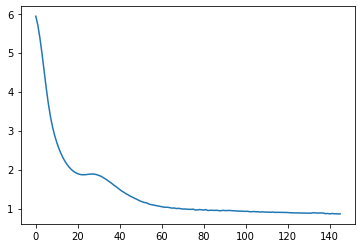

In [24]:
plt.plot(loss_over_time)

In [25]:
#torch.set_printoptions(edgeitems=3)

batch_size = 3
x, z, actual, pad = get_batch(val_data, test_padding_map, 1)

In [26]:
print(actual.shape)
actual

torch.Size([16, 3, 768])


tensor([[[-9.0457e-01,  1.2714e-02,  4.9749e-01,  ...,  1.8895e+00,
           8.6814e-01, -3.7130e-01],
         [-1.7216e-01, -4.6049e-01,  2.5054e-01,  ...,  1.2910e+00,
           1.2516e+00,  5.0627e-01],
         [-4.8508e-01, -5.1946e-02,  1.8242e-01,  ...,  7.7027e-01,
           7.8208e-01, -8.9879e-03]],

        [[-5.3514e-01, -2.8362e-01,  9.0634e-01,  ...,  8.5750e-01,
           8.7612e-01, -1.7978e-01],
         [-2.5939e-03,  1.2943e-01, -1.0862e-01,  ...,  6.9449e-02,
           6.6726e-01, -7.2774e-02],
         [-3.0401e-01, -6.2218e-02,  6.5759e-01,  ...,  4.7975e-01,
           9.8095e-01,  5.0123e-01]],

        [[-7.3030e-01, -1.7939e-01,  2.3337e-01,  ...,  7.3753e-01,
           9.7322e-01,  8.1784e-02],
         [-5.4677e-01,  4.0596e-01,  2.7073e-01,  ...,  4.4434e-01,
           6.5584e-01,  8.3244e-02],
         [-2.4833e-01, -6.9638e-01,  4.4997e-01,  ...,  7.6136e-01,
           2.2312e-01,  1.9022e-01]],

        ...,

        [[-5.7896e-01,  1.7959e-01,

Encoder Attention
Decoder Attention
Encoder-Decoder Attention
0.9233057498931885


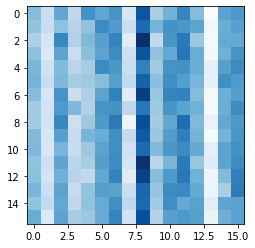

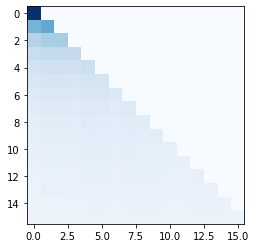

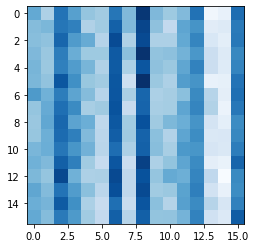

In [27]:
best_model.eval()

with torch.no_grad():
    prediction, enc_att, dec_att, mult_attn = best_model.predict(x, z, pad)

plt.imshow(enc_att[0, 0, :, :].squeeze().detach().cpu().numpy(), cmap='Blues')
print("Encoder Attention")
plt.show()
plt.imshow(dec_att[0, :, :].squeeze().detach().cpu().numpy(), cmap='Blues')
print("Decoder Attention")
plt.show()
plt.imshow(mult_attn[0, :, :].squeeze().detach().cpu().numpy(), cmap='Blues')
print("Encoder-Decoder Attention")
plt.show()

loss = calculate_loss(prediction, actual)
print(loss.item())

In [28]:
print("x:")
print(x[:, 0, 0])
print("z:")
print(z[:, 0, 0])
print("----------------------------")
print("actual:")
print(actual[:, 0, 0:3])
print("pred:")
print(prediction[:, 0, 0:3])


x:
tensor([-1.0717, -0.8808, -0.9046, -0.5351, -0.7303, -0.0688,  0.2847,  0.3518,
         0.0243, -0.3431, -0.1168, -0.7088, -0.1699, -0.6593, -0.1676, -0.5790],
       device='cuda:0')
z:
tensor([-0.8808, -0.9046, -0.5351, -0.7303, -0.0688,  0.2847,  0.3518,  0.0243,
        -0.3431, -0.1168, -0.7088, -0.1699, -0.6593, -0.1676, -0.5790, -0.5428],
       device='cuda:0')
----------------------------
actual:
tensor([[-0.9046,  0.0127,  0.4975],
        [-0.5351, -0.2836,  0.9063],
        [-0.7303, -0.1794,  0.2334],
        [-0.0688, -0.8595,  0.5319],
        [ 0.2847, -0.5828,  0.3962],
        [ 0.3518,  0.7067,  0.7314],
        [ 0.0243, -0.2605, -0.1588],
        [-0.3431,  0.0356,  0.2591],
        [-0.1168,  0.5269, -0.3710],
        [-0.7088, -1.0321, -0.0255],
        [-0.1699, -0.2010,  0.1341],
        [-0.6593, -0.5567, -0.0046],
        [-0.1676,  0.1457,  0.0438],
        [-0.5790,  0.1796, -0.0608],
        [-0.5428, -1.8050,  0.3337],
        [-0.3465,  0.2150,  0.10

Create a lookup table for calculating recall and accuracy

In [29]:
def extract_article_bert_tuple(data):
    return { article_and_bert["_1"]: article_and_bert["_2"] for article_and_bert in data }

In [30]:
raw_lookup = read_multi_json_objects_file("../data/lookup.json")

In [31]:
article_bert_lookup = extract_article_bert_tuple(raw_lookup)

bert_vectors: List[List[float]] = list(article_bert_lookup.values())
article_ids: List[int]          = list(article_bert_lookup.keys())

In [32]:
pred = []
real = []
for i in range(batch_size):
    for j in range(decoder_seq_length):
        pred.append(prediction[j, i, :].detach().cpu().numpy())
        real.append(actual[j, i, :].detach().cpu().numpy())

In [33]:
def get_calculated_similarities(bert_pred) -> List[List[float]]:
    return cosine_similarity(bert_pred, bert_vectors).tolist()

def get_article_for(similarities: List[float]) -> int:
    article_id_index = similarities.index(max(similarities))
    return article_ids[article_id_index]

def get_actual_article(bert_actual: List[float]) -> int:
    article_id_index = bert_vectors.index(bert_actual)
    return article_ids[article_id_index]

In [34]:
pred_similarities: List[List[float]] = get_calculated_similarities(pred)
articles_pred: List[int] = [ get_article_for(pred_similarity) for pred_similarity in pred_similarities ]

In [35]:
true_similarities: List[List[float]] = get_calculated_similarities(real)
articles_true: List[int] = [ get_article_for(true_similarity) for true_similarity in true_similarities ]

In [36]:
print(articles_pred)
print(articles_true)

[710644733, 710644733, 710644733, 710644733, 734062063, 731868563, 734062063, 734062063, 710644733, 227552441, 227552441, 710644733, 710644733, 710644733, 710644733, 737480976, 710644733, 666216061, 666216061, 710644733, 710644733, 710644733, 737480976, 710644733, 737480976, 710644733, 710644733, 666216061, 710644733, 710644733, 710644733, 710644733, 710644733, 710644733, 710644733, 710644733, 710644733, 710644733, 710644733, 710644733, 710644733, 710644733, 710644733, 710644733, 710644733, 710644733, 710644733, 710644733]
[731227949, 731452667, 738928041, 561377567, 738883014, 688037077, 740030469, 742062385, 705882024, 736150288, 741840092, 727231175, 703055624, 683718636, 742524127, 742558748, 700752395, 740884807, 715665631, 741170897, 741408143, 742044694, 742398083, 741645955, 740114922, 708343797, 732090776, 725478662, 741673105, 742068951, 669289018, 726374141, 741116757, 733960089, 729569284, 725923921, 724456012, 740884807, 738798794, 741170897, 607660747, 700759122, 74239808

In [37]:
accuracy_score(articles_true, articles_pred)

0.0